In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets
Representa la tasa de deposición de polvo del conjunto de datos empíricos en los lugares de medición y los datos simulados en la cuadrícula global.

In [4]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

# visualizar el df
df_empirical_Holocene

,lon,lat,dep,log_dep,log_dep_norm
0,1.37,78.87,3.999995,0.602059,0.185196
1,-61.00,77.00,0.040000,-1.397941,-1.669137
2,-42.32,75.10,0.008000,-2.096911,-2.317199
3,-6.72,74.58,3.100001,0.491362,0.082561
4,-37.63,72.58,0.009000,-2.045758,-2.269772
...,...,...,...,...,...
392,0.00,-75.00,0.002000,-2.698970,-2.875408
393,123.35,-75.10,0.000400,-3.397941,-3.523470
394,107.00,-78.00,0.000700,-3.154901,-3.298132
395,107.00,-78.00,0.000400,-3.397941,-3.523470


In [5]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [6]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


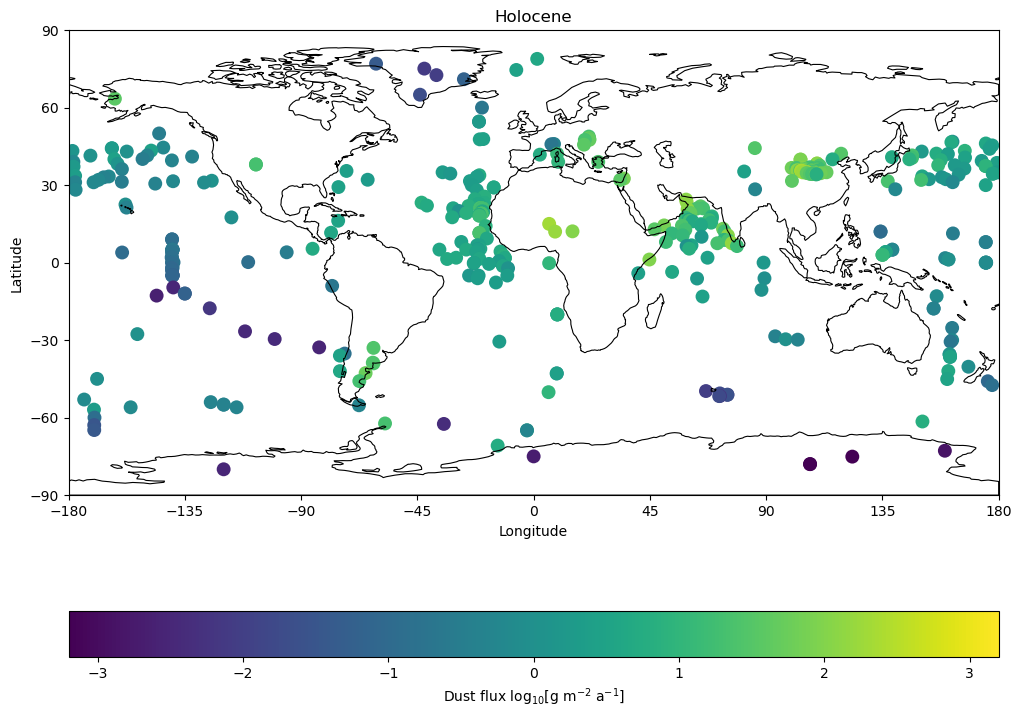

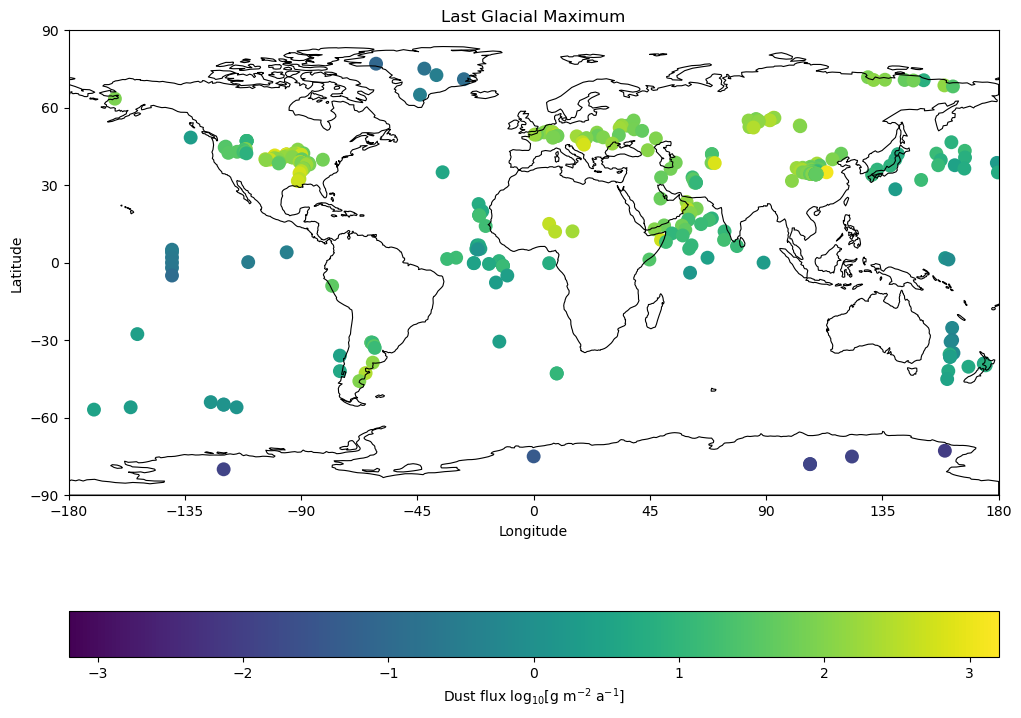

In [7]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [8]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

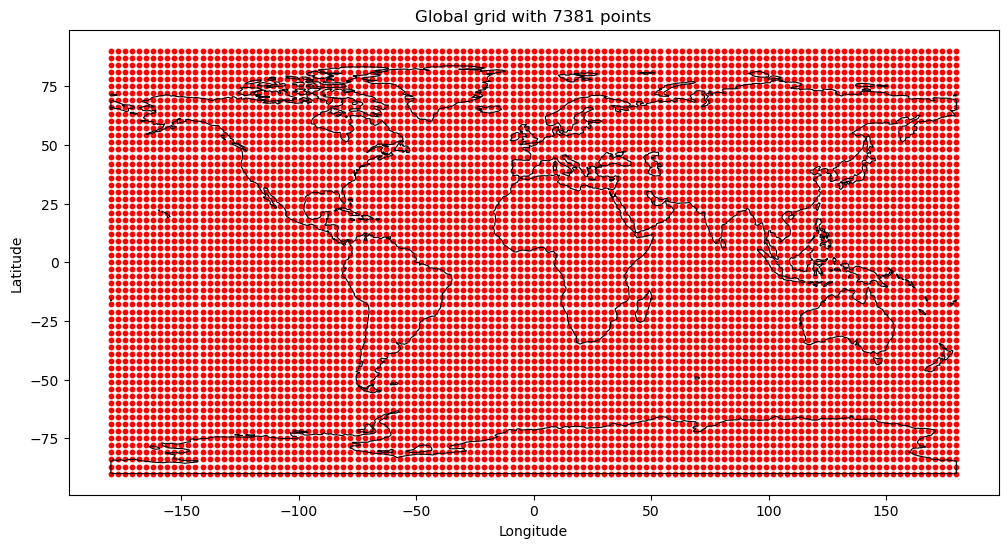

In [9]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [10]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

### Funcion que calcula la distancia geodesica, punto (2) de la tarea

In [11]:
# por mi felicidad, escribí esta funcion en español :>
def distance_geodesic(x, y):
    """
    Calcula la distacia Geodesica entre dos puntos en la tierra.

    Parameters:
    x,y : Iterable
        Vectores en dos dimensiones que representan dos puntos en el plano.
        para los vectores, (x_1,x_2) e (y_1,_y2) x_1,y_1 representa longitud 
        y x_2, y_2 representará latitud
    """

    # radio de la tierra en metros
    Radio_tierra = 637100

    # para mayor precision pasamos las coordenadas a radianes
    long_1 = np.radians(x[0])
    long_2 = np.radians(y[0])
    lat_1= np.radians(x[1])
    lat_2= np.radians(y[1])

    # aplicar la siguiente formula Rarc cos (sen(φ1) sen(φ2) + cos(φ1) cos(φ2) cos(λ2 −λ1))
    # formula traducida del enunciado a python por ChatGpt
    distancia=  Radio_tierra * (np.arccos((np.sin(lat_1) * np.sin(lat_2)) + (np.cos(lat_1) * np.cos(lat_2) * np.cos(long_2 - long_1))))
    
    return distancia


In [12]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic

        
    else:
        distance_fun = distance_euclidean
        
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [13]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

### Vizualizando los mapas con estimación que utiliza la distancia euclideana 

In [14]:
estimations_holocene_eu = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_eu = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_eu[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist = 'euclidean')
    estimations_lgm_eu[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist = 'euclidean')
    
df_global_grid["est_hol"] = estimations_holocene_eu
df_global_grid["est_lgm"] = estimations_lgm_eu

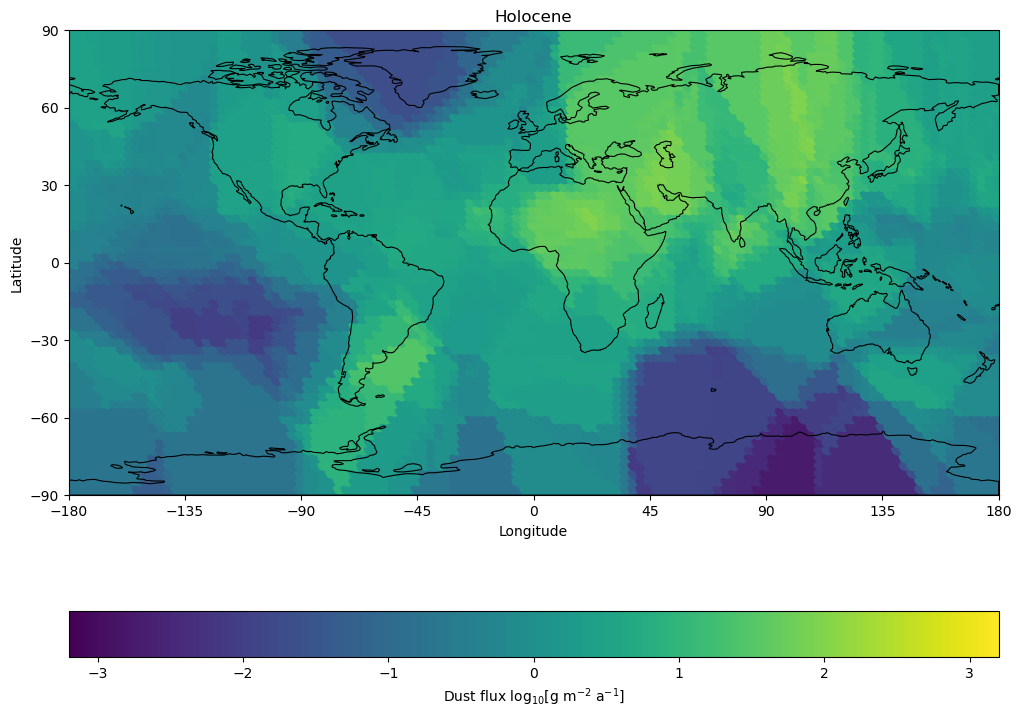

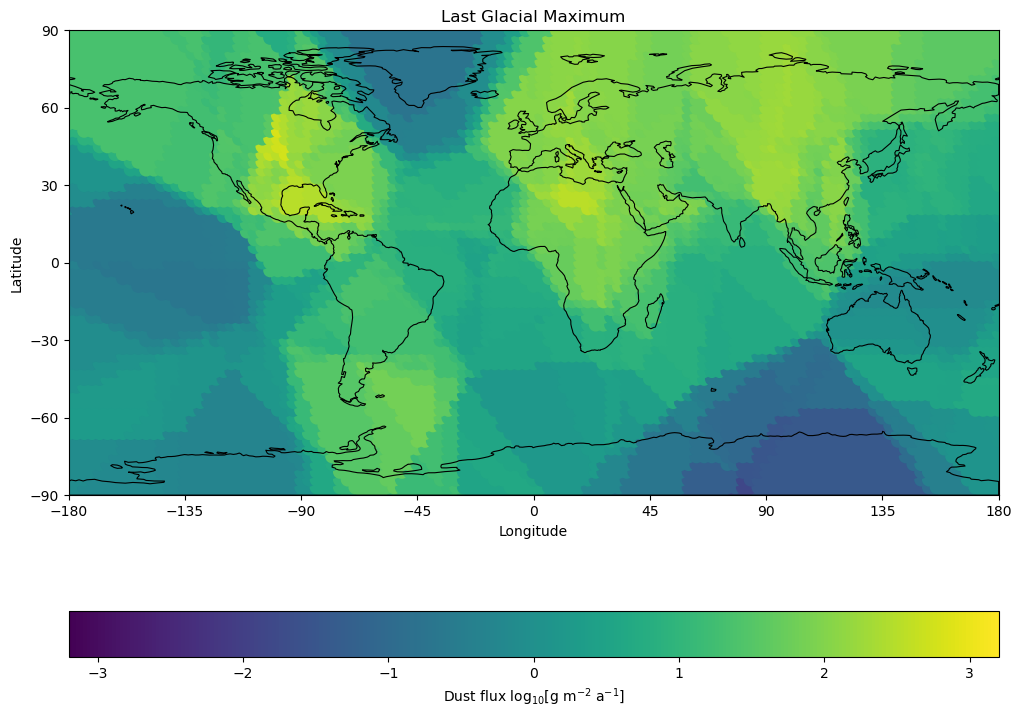

In [15]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

## Estimación utilizando la distancia geodésica

La tasa de deposición de polvo se estimará promediando los valores de los k vecinos más cercanos.

In [16]:
estimations_holocene_geo = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geo = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geo[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist = 'geodesic')
    estimations_lgm_geo[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist = 'geodesic') 

df_global_grid["est_hol_geodesic"] = estimations_holocene_geo
print(estimations_holocene_geo)
df_global_grid["est_lgm_geodesic"] = estimations_lgm_geo

[-3.03452615 -3.03452615 -3.03452615 ... -0.88943751 -0.88943751
 -0.88943751]


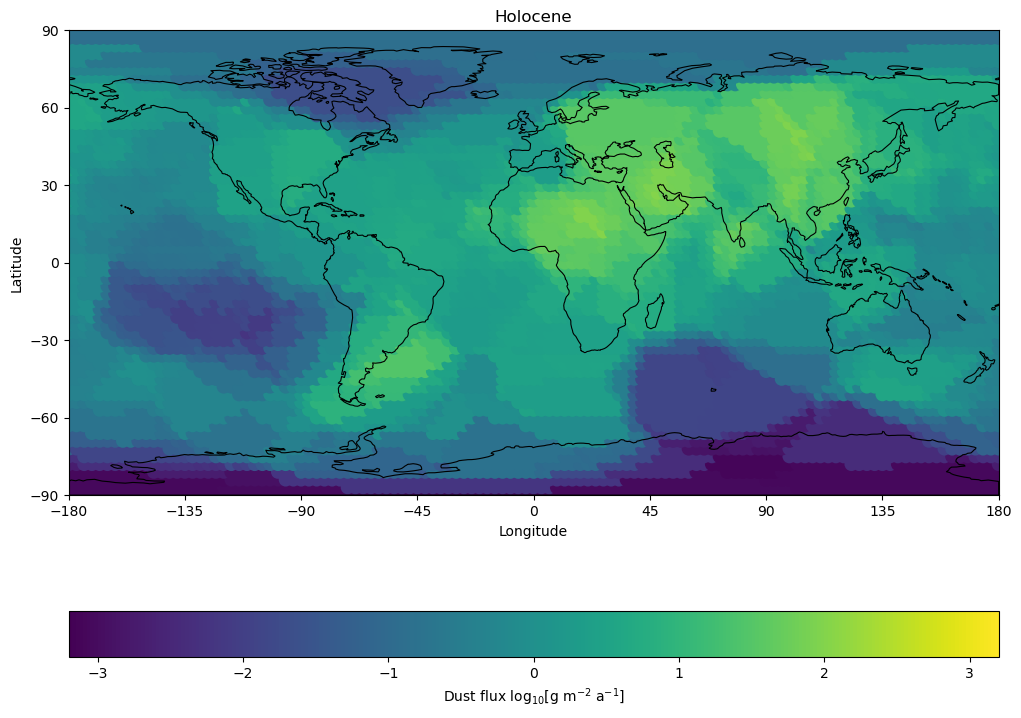

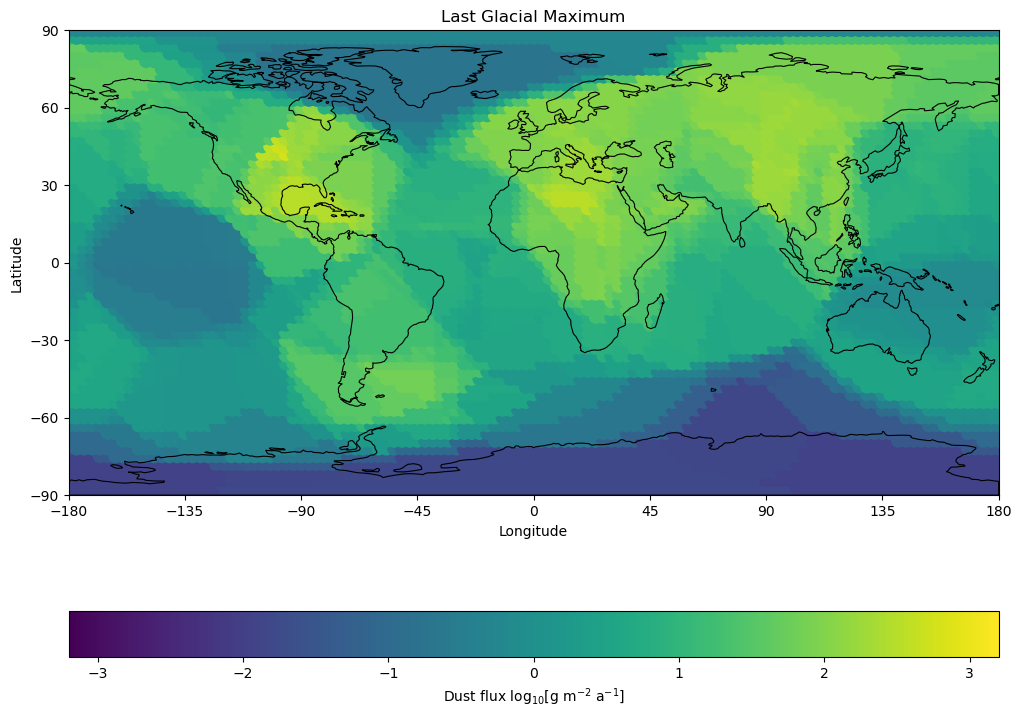

In [17]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_geodesic')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_geodesic')

## vizualizando las diferencias entre ambos metodos.

Las siguientes líneas de código actualizan el DataFrame incorporando columnas para las diferencias y generan un nuevo mapa que representa dichas diferencias en diversas regiones del mundo.

In [18]:

# crea nuevas columnas en el df para las magnitudes de las diferencias de los metodos 
df_global_grid['est_hol_dif'] = abs(df_global_grid['est_hol_geodesic'] - df_global_grid['est_hol'])
df_global_grid['est_lgm_dif'] = abs(df_global_grid['est_lgm_geodesic'] - df_global_grid['est_lgm'])

In [19]:
# mapa copiado del ejemplo del profesor, pequeños cambios realizados en los nombres y el rango de valores

def plot_dust_diference_map(df, title, name_to_save, label_str='log_dep', measure_units='magnitud de diferencia'):

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           # se pidió ayuda a chatgpt para establecer los valores de 0 a 4 
                           vmin=0,  
                           vmax=4,  
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    plt.show()

    return


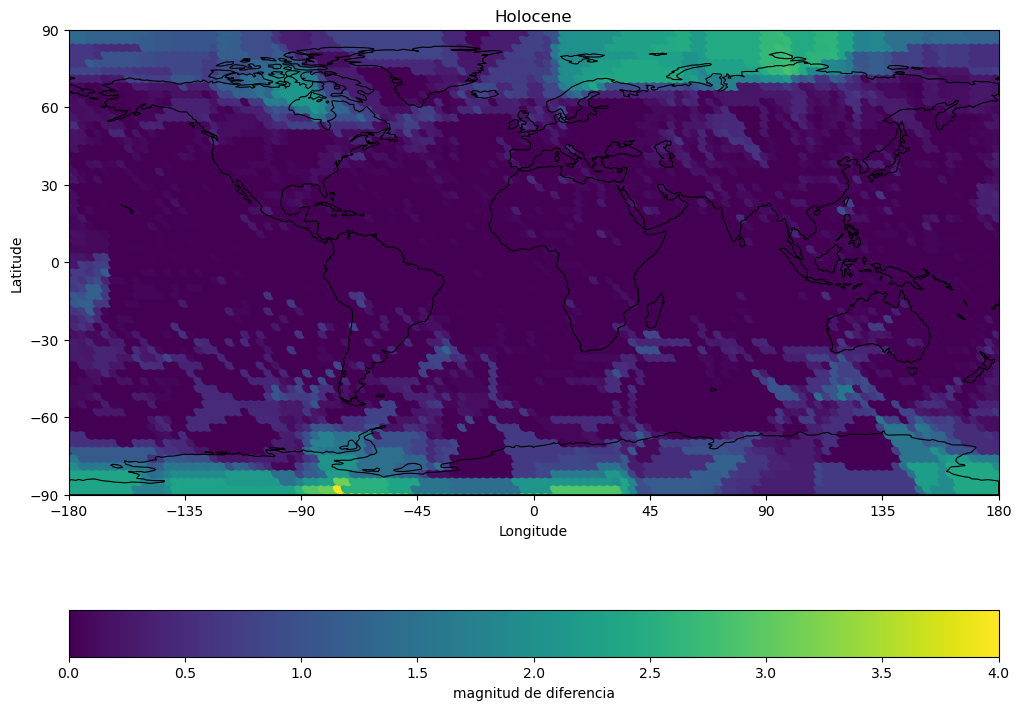

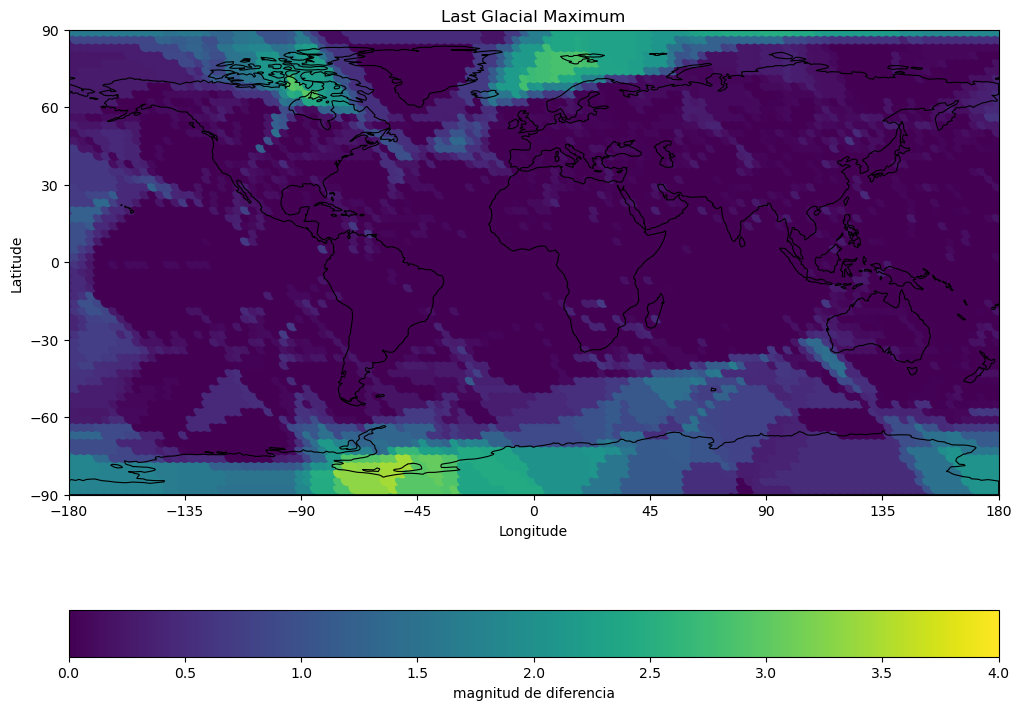

In [20]:
plot_dust_diference_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_dif'
                         )

plot_dust_diference_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_dif'
                         )


### `Concluciones`


Los mapas presentados ilustran la magnitud de la diferencia en la aplicación de los métodos con distintas definiciones de distancia para los periodos *holocene* y *LGM*. Las zonas con mayor concentración de puntos amarillos corresponden a aquellas donde se observó la mayor disparidad en las estimaciones, mientras que los puntos en tonos morados representan una diferencia menor y más cercana a cero.

## Analisís de resultados.

### Punteo:

* ¿Por qué las diferencias son m ́as grandes en una parte que otra
parte del mundo?

* ¿Cuál método es más fidedigno en los polos sur y norte?

* ¿Cuál método es más fidedigno en longitud 180◦?

* ¿Cuáles son las diferencias entre los resultados para el Holoceno
y el LGM?

* ¿Cómo elegir el n ́umero de vecinos cercanos?


### Distancia Planar y Distancia Geodésica: 

La comprensión de las diferencias entre la distancia planar y la distancia geodésica es crucial para modelar con precisión fenómenos que involucran la distribución espacial, como el flujo de polvo en la atmósfera. El link citado al final de este texto detalla las siguientes diferencias:

*Distancia Euclidiana:*

La distancia euclidiana, se calcula en un plano bidimensional utilizando el teorema de Pitágoras. Esta medida representa la distancia en línea recta entre dos puntos, sin considerar la curvatura de la Tierra. Su simplicidad la hace útil para cálculos rápidos en áreas pequeñas.

*Distancia Geodésica:*

La distancia geodésica, por otro lado, toma en cuenta la curvatura de la Tierra y calcula la distancia real a lo largo de la superficie terrestre. Se utiliza una fórmula matemática que considera la latitud y longitud de los puntos involucrados. Este método es más preciso, especialmente en áreas extensas, regiones polares y zonas con topografía irregular.


### Puntos de  diferencias:

La discrepancia entre las distancias planar y geodésica aumenta proporcionalmente con la distancia entre los puntos y el tamaño del área de estudio.  además , se pudo observar que 
Las regiones donde la diferencia entre la distancia plana y la geodésica es más notables son:

En el Ártico y la Antártida, en las regiones más acercadas a los polos la Tierra se vuelve más achatada, Esto la discrepancia entre ambos métodos. La distancia geodésica es esencial en estas zonas.


### Análisis de la Latitud 180°:

En la latitud 180°, se presentan diferencias  entre las distancias planar y geodésica. Esto se debe a que a lo largo de una longitud completa, la distancia recorrida varía, siendo más notoria la diferencia en los polos. Por lo tanto, para realizar mediciones precisas a lo largo de este meridiano, es preferible utilizar la distancia geodésica.

### Diferencias en Resultados para Holoceno y LGM:

Al comparar mapas del flujo de polvo en el Holoceno y el Último Máximo Glacial (LGM), se observan diferencias en las estimaciones. Esto puede atribuirse a dos factores:

*Cambios Climáticos:* Las condiciones climáticas han variado significativamente entre el Holoceno y el LGM, lo que afecta los patrones de flujo de polvo.

*Disponibilidad de Datos:* se observa que el mapa del LGM tiene menos puntos que el del Holoceno, lo que puede afectar la precisión de las estimaciones.


## Selección del Número de Vecinos Apropiado:

En el método de vecinos cercanos, Un valor de k vecinos demasiado pequeño puede conducir a una subestimación del flujo de polvo, al considerar muy pocos puntos de referencia para calculr la estimación, mientras que un valor demasiado grande puede generar resultados alterados, al considerar puntos muy lejanos del planeta, estará estimando de manera erronea los flujos de polvo en un sector en específico. La selección adecuada de k depende de la distribución espacial de los datos y de la nesesidad de precisión.

*Técnicas de Validación Cruzada :*

Para evaluar la precisión de las estimaciones obtenidas con el método de vecinos cercanos, dado un cierto K de vecinos, se pueden utilizar técnicas de validación cruzada.

### información externa utilizada:

*Información utilizada sobre las diferencias entre la distancia geodésica y la euclidiana obtenida del siguiente enlace:* https://pro.arcgis.com/en/pro-app/3.1/tool-reference/spatial-analyst/geodesic-versus-planar-distance.htm


*Información sobre la validación cruzada obtenida de:* https://datascientest.com/en/data-courses

